## Desenvolvimento do Case: Modelo preditivo de Churn

## Importando Libs Necessárias

In [1]:
from sklearn import preprocessing
#import cloudpickle as cp
import matplotlib.pyplot as plt 
from sklearn.base import BaseEstimator, TransformerMixin
plt.rc("font", size=14)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
import joblib
sns.set(style="whitegrid", color_codes=True)
import pandas as pd                                    # Manipulação de tabelas
import numpy as np                                     # Operações matemáticas
import warnings                                        # Remover warnings
import gc                                              # Limpa memória do cache
#from pandas_profiling import ProfileReport
from sklearn.metrics import roc_auc_score
from sklearn import datasets, linear_model
from sklearn.model_selection import StratifiedKFold    # Cria KFold estratificado
from sklearn.model_selection import RandomizedSearchCV # Busca Aleatória de Parâmetros
import scipy.stats
warnings.filterwarnings("ignore")             # Ignora warnings
pd.set_option('display.max_columns', None)    # Remove limitador de colunas quando mostra a tabela

## Importação da Base de Dados

In [2]:
base_raw = pd.read_csv('Abandono_clientes.csv')

In [3]:
base_raw_backup = base_raw.copy()

In [4]:
base_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## 1. Breve Descritivo e Exploratório das Variáveis

In [5]:
print('As variáveis presentas na base de dados são:',base_raw.columns.values)

As variáveis presentas na base de dados são: ['RowNumber' 'CustomerId' 'Surname' 'CreditScore' 'Geography' 'Gender'
 'Age' 'Tenure' 'Balance' 'NumOfProducts' 'HasCrCard' 'IsActiveMember'
 'EstimatedSalary' 'Exited']


### 1.1 Análise Gráfica e Tratamento de Outliers das Variáveis Preditoras do Churn

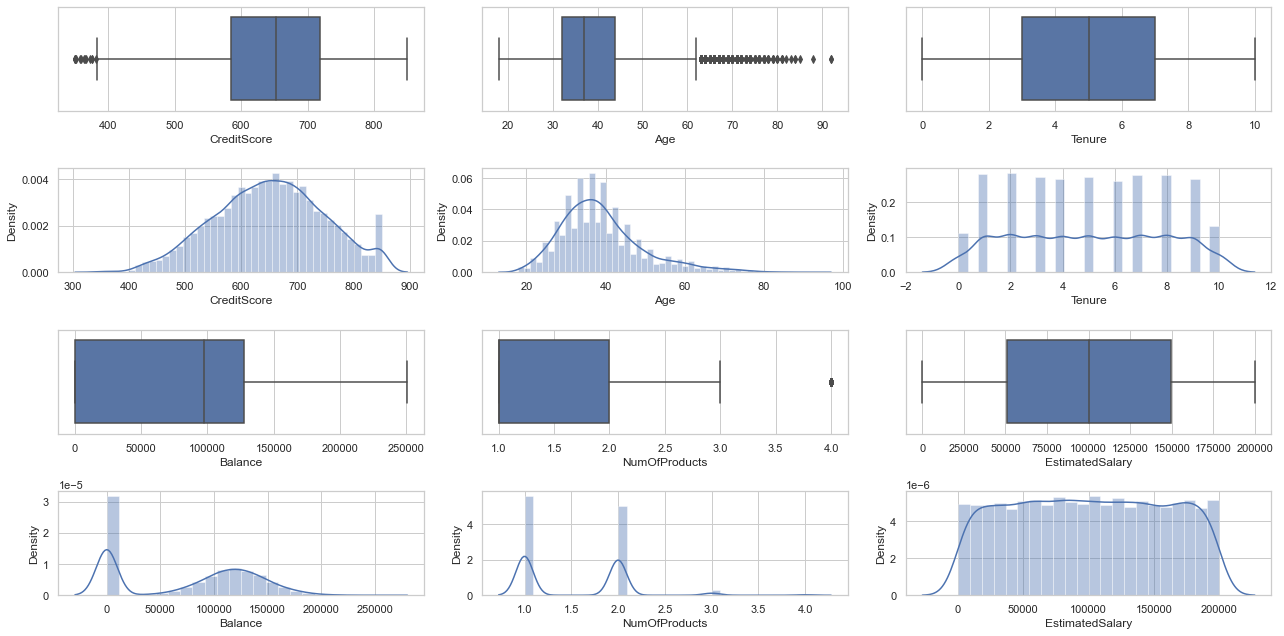

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=4, figsize=(18,9))

sns.boxplot(base_raw['CreditScore'], ax=axs[0,0])
sns.boxplot(base_raw['Age'], ax=axs[0,1])
sns.boxplot(base_raw['Tenure'], ax=axs[0,2])
sns.boxplot(base_raw['Balance'], ax=axs[2,0])
sns.boxplot(base_raw['NumOfProducts'], ax=axs[2,1])
sns.boxplot(base_raw['EstimatedSalary'], ax=axs[2,2])

sns.distplot(base_raw['CreditScore'], ax=axs[1,0])
sns.distplot(base_raw['Age'], ax=axs[1,1])
sns.distplot(base_raw['Tenure'], ax=axs[1,2])
sns.distplot(base_raw['Balance'], ax=axs[3,0])
sns.distplot(base_raw['NumOfProducts'], ax=axs[3,1])
sns.distplot(base_raw['EstimatedSalary'], ax=axs[3,2])

fig.tight_layout()

In [7]:
class TrataOutlier(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.li = {}
        self.ls = {}
        self.num_cols = None
    
    def fit(self, X, y=None):
        self.num_cols = X.select_dtypes('number').columns.tolist()
        for col in self.num_cols:
            q1, q3 = X[col].quantile(q=[.25, .75])
            iqr = q3 - q1
            li = q1 - 1.5 * iqr
            ls = q3 + 1.5 * iqr
            
            self.li[col] = li
            self.ls[col] = ls
        return self
    
    def transform(self, X):
        for col in X.select_dtypes('number').columns:
            if col not in self.num_cols:
                print(f'Coluna {col} não existe na tabela')
                pass
            else:
                X.loc[X[col] < self.li[col], col] = self.li[col]
                X.loc[X[col] > self.ls[col], col] = self.ls[col]
        
        return X

In [8]:
trata_outlier = TrataOutlier()
cols_numericas = ['CreditScore','Age',
                  'Tenure','Balance',
                  'NumOfProducts','EstimatedSalary']
base_raw.loc[:, cols_numericas] = trata_outlier.fit_transform(base_raw[cols_numericas])

### 1.2 Análise Gráfica de Variáveis Categóricas

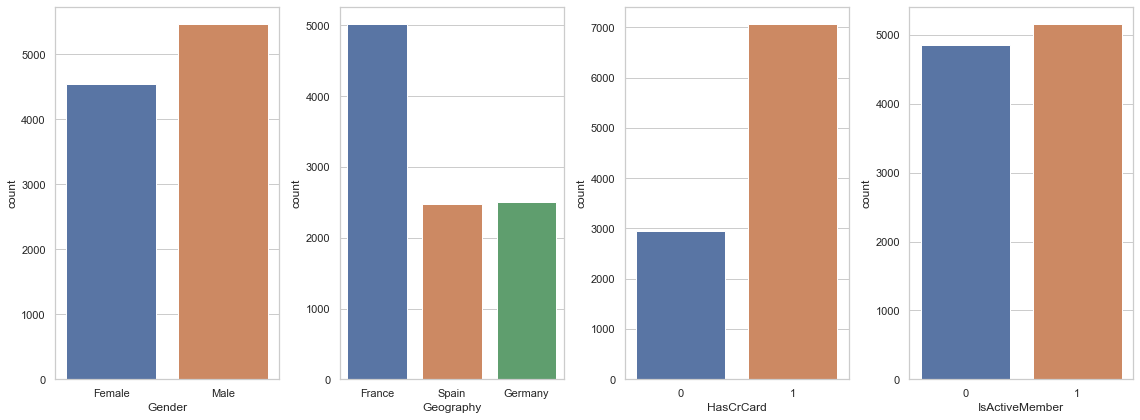

In [9]:
fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(16,6))

sns.countplot(base_raw['Gender'], ax=axs[0])
sns.countplot(base_raw['Geography'], ax=axs[1])
sns.countplot(base_raw['HasCrCard'], ax=axs[2])
sns.countplot(base_raw['IsActiveMember'], ax=axs[3])

fig.tight_layout()

In [10]:
 # COLLECT DUMMIES
features_categoricas = ['Gender', 'Geography']
base_raw = pd.get_dummies(base_raw, columns= features_categoricas, drop_first = True)

In [11]:
base_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2,0.00,1.0,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,1.0,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8,159660.80,3.0,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1,0.00,2.0,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1.0,1,1,79084.10,0,0,0,1


### 1.3 Análise do Balanceamento da Variável Resposta

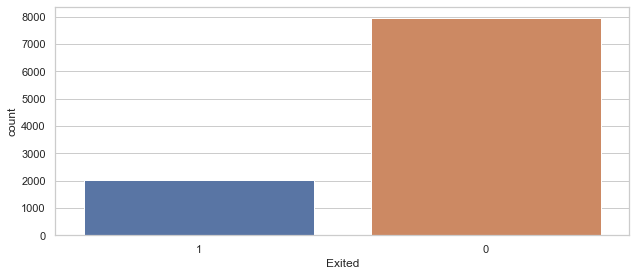

In [12]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(9,4))
sns.countplot(base_raw['Exited'].apply(str))
fig.tight_layout()

In [13]:
print('A Disposição da variável resposta na base de dados é:'),
print(round((base_raw['Exited'].value_counts()/base_raw.shape[0])*100,2),'em %')

A Disposição da variável resposta na base de dados é:
0    79.63
1    20.37
Name: Exited, dtype: float64 em %


## 2. Aplicação do Classificador XGBOOST para Modelagem do Churn

### 2.1 Classe de Modelagem do XGBOOST (Obs: Performance Estimada a partir da métrica AUC)

In [14]:
class Modelagem:
    
    def __init__(self):
        
        """
            Verifica se pacotes estão instalados. Se não estiver, sugere instalar.
        """
        
        # XGBoost
        try:
            import xgboost as xgb
        except ImportError as e:
            print('Instalar XGBoost. Execute o seguinte comando: !pip install "xgboost==0.90"')
        
        # Scikit-Learn
        try:
            import sklearn
        except ImportError as e:
            print('Instalar Scikit-Learn. Execute o seguinte comando: !pip install "sklearn==0.20.2"')
            
        # Otimização Bayesiana
        try:
            import optuna
        except ImportError as e:
            print('Instalar Optuna. Execute o seguinte comando: !pip install "optuna==1.0.0"')
        
        # Funções estatísticas
        try:
            import scipy.stats
        except ImportError as e:
            print('Instalar Scipy. Execute o seguinte comando: !pip install "scipy==1.2.0"')
        
        # Pickle -> serialização de modelos
        try:
            import pickle as pkl
        except ImportError as e:
            print('Instalar Pickle. Execute o seguinte comando: !pip install "pickle==4.0"')
            
        print('Conjunto de funções para construção de modelos de machine learning')
 
  
    def validacao_cruzada_xgb(self, X, y, n_splits=5, shuffle=True, n_jobs=2, n_iter=5, random_state=42):
        """
            Treina o XGBoost a partir de uma Validação Cruzada Estratificada ( StratifiedKFold ) com RandomizedSearchCV

            Parâmetros
            ----------
            X            : pandas dataframe. Base que irá treinar o modelo.
            y            : array. Target do modelo.
            n_splits     : inteiro. Número de folds para a validação cruzada.
            shuffle      : booleano. Faz splits aleatórios com reposição.
            n_jobs       : inteiro. Número cores que serão usados para processamento. -1 faz usar todos disponíveis.
            n_iter       : inteiro. Número de vezes que a validação cruzada será executada.
            random_state : inteiro. Semente de aleatoriedade.

            Retorna
            -------
            rs_grid.best_estimator_ : Melhor classificador da validação.
        """
        import xgboost as xgb
        from sklearn.metrics import roc_auc_score              # Calcula ROC
        from sklearn.model_selection import StratifiedKFold    # Cria KFold estratificado
        from sklearn.model_selection import RandomizedSearchCV # Busca Aleatória de Parâmetros,
            
        # Cria amostras estratificadas
        cv = StratifiedKFold(
            n_splits     = n_splits,
            shuffle      = shuffle,
            random_state = random_state
        )
        
        # Parâmetros padrão do modelo
        params_fixed = {
            'objective': 'binary:logistic',   # Objetivo do modelo
            'silent'   : 1,                   # Atualiza status do modelo. 0 para não mostrar e 1 para mostrar (bom para debub)
            'seed'     : random_state,        # Semente
            'n_jobs'   : -1                   # Numero de cores do processador. -1 usa todos disponíveis
        }
        
        params_dist_grid = {
            
            # Profundidade máxima da árvore. Valores muito altos podem overfittar.
            'max_depth'        : [1, 2, 3, 4, 5, 6, 7],
            
            # Determina o mínimo de redução de perda necessário para criar um split. Deixa o algoritmo conservador.
            'gamma'            : [0, 0.5, 1],
            
            # Número de estimadores para o modelo. Valores muito altos podem overfittar.
            'n_estimators'     : scipy.stats.randint(1, 1001),
            
            # Taxa de aprendizado. Valores muito pequenos deixam o modelo mais lento para treinar.
            'learning_rate'    : scipy.stats.uniform(),
            
            # Determina a fração de observações a serem consideradas quando constrói cada árvore.
            # Tianqi Chen e Carlos Guestrin, no paper do XGBoost, recomendam o uso desse parâmetro.
            'subsample'        : scipy.stats.uniform(),
            
            # Determina a fração de colunas a serem escolhidas, randomicamente, para cada árvore.
            'colsample_bytree' : scipy.stats.uniform(),
            
            # Regularização L1. Incentiva a esparsidade -> fazer os pesos tenderem a 0.
            # Pode ser útil quando o objetivo é "objective: binary:logistic" desde que eu precise de ajuda
            # na seleção de variáveis.
            'reg_alpha'        : scipy.stats.uniform(),
            
            # Regularização L2. Incentiva pesos pequenos
            # Essa abordagem pode ser mais útil em métodos de árvore ao zerar as variáveis que não fazem sentido.
            'reg_lambda'       : scipy.stats.uniform(),
        }
        
        # Faz a validação cruzada com as amostras estratificadas
        rs_grid = RandomizedSearchCV(
            estimator=xgb.XGBClassifier(**params_fixed),   # Modelo a ser otimizado
            n_jobs=n_jobs,
            verbose=1,
            param_distributions=params_dist_grid,          # Parâmetros a serem otimizados
            n_iter=n_iter,
            cv=cv,                                         # Objeto de validação cruzada
            scoring='roc_auc',                             # Métrica
            random_state=random_state,
        )
        
        rs_grid.fit(X, y)                                   # Otimiza modelo
        
        print('=' * 80)
        print('Melhores parâmetros:', rs_grid.best_params_)  # Printa os melhores parâmetros
        print('Melhor ROC:', rs_grid.best_score_)            # Printa o melhor ROC

        return rs_grid.best_estimator_                       # Retorna o melhor modelo      
    
    def calcula_ks(self, df, var_score, target, retorna_valor=False):
        """
            Calcula o KS do Score

            Parâmetros
            ----------
            df            : pandas dataframe. Dataframe da base escorada.
            var_score     : string. Nome da variável de score.
            target        : string. Nome da variável target.
            retorna_valor : booleano. Define se retorna valor do KS.

            Retorna
            -------
            rs_grid.best_estimator_ : Melhor classificador da validação.
        """
        
        df_ks, valor_ks = TuringEvaluateModels(df, var_score, target)
        print('KS:', valor_ks)
        if retorna_valor:
            display(df_ks)
            return valor_ks
        else:
            return df_ks
    
    def score_validacao_cruzada(self, estimador, X, y, cv=5, n_jobs=-1, scoring='roc_auc', retorna=False):
        """
            Calcula o score na validação cruzada

            Parâmetros
            ----------
            estimador  : modelo. Modelo que irá escorar a base
            X          : pandas dataframe. Conjunto de treino do modelo
            y          : array. Array com as targets para cada individuo
            cv         : inteiro. Número de folds para validação. 
            n_jobs     : inteiro. Número de cores a serem usados para processamento. -1 faz usar todos disponíveis
            scoring    : string. Métrica de desempenho.
            retorna    : booleano. Define se retorna score.

            Retorna
            -------
            rs_grid.best_estimator_ : Melhor classificador da validação.
        """
        
        inicio = time.time()
        
        # Calcula scores de validação cruzada
        roc_scores = cross_val_score(
            estimator = estimador, 
            X         = X, 
            y         = y, 
            cv        = cv, 
            n_jobs    = n_jobs, 
            scoring   = scoring
        )

        roc_mean = roc_scores.mean()
        roc_std  = roc_scores.std()
        fim      = time.time() - inicio
        
        print("Média da " + scoring + " na Validação Cruzada: ", round(roc_mean, 3))
        print("Desvio Padrão da " + scoring + " na Validação Cruzada: ", round(roc_std, 3))
        print("Tempo de processamento: ", round(fim, 3), 'segundos')
        
        if retorna:
            return {'media': roc_mean, 'desvio': roc_std}

### 2.2 Demais Funções Complementares

In [15]:
### Função que mostra dataframe lado a lado
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
def metricas(scores,target):
    return pd.DataFrame({
        'KS'   : [ks2(scores,target)],
        'ROC'  : [roc_auc_score(y_score=scores,y_true=target)],
        'GINI' : [2 * roc_auc_score(y_score=scores,y_true=target) - 1]
    })
def ks2(score, alvo):
    b2 = pd.crosstab(score, alvo, rownames = ['score']).reset_index()
    if len(np.unique(alvo)) > 1:
        freq_bom = b2.iloc[:,1]/sum(b2.iloc[:,1])
        freq_mau = b2.iloc[:,2]/sum(b2.iloc[:,2])
        ac_bom = np.cumsum(freq_bom)
        ac_mau = np.cumsum(freq_mau)
        diff = np.abs(ac_bom - ac_mau).round(7)
        ks = diff.max() * 100
    else:
        ks = 0
    return ks

In [16]:
base_raw.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender_Male,Geography_Germany,Geography_Spain
0,1,15634602,Hargrave,619,42,2,0.00,1.0,1,1,101348.88,1,0,0,0
1,2,15647311,Hill,608,41,1,83807.86,1.0,0,1,112542.58,0,0,0,1
2,3,15619304,Onio,502,42,8,159660.80,3.0,1,0,113931.57,1,0,0,0
3,4,15701354,Boni,699,39,1,0.00,2.0,0,0,93826.63,0,0,0,0
4,5,15737888,Mitchell,850,43,2,125510.82,1.0,1,1,79084.10,0,0,0,1


### 2.3 Aplicação o XGBOOST

In [17]:
NOME_DA_TARGET = 'Exited'
modelagem =  Modelagem() 
xgb_model = modelagem.validacao_cruzada_xgb(base_raw.drop(['RowNumber','CustomerId','Surname',NOME_DA_TARGET],axis=1), base_raw[NOME_DA_TARGET], n_jobs = -1,n_splits=5,n_iter=5)

Conjunto de funções para construção de modelos de machine learning
Fitting 5 folds for each of 5 candidates, totalling 25 fits
[15:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:57:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Melhores parâmetros: {'colsample_bytree': 0.8661761457749352, 'gamma': 1, 'learning_rate': 0.020584494295802447, 'max_depth': 2, 'n_estimators': 344

In [18]:
import pickle as pkl
pkl.dump(xgb_model, open('model.pkl', 'wb'))

### 2.4 Análise de Performance Global Esperada

In [19]:
probabilidades_predicoes= xgb_model.predict_proba(base_raw.drop(['RowNumber','CustomerId','Surname',NOME_DA_TARGET],axis=1)) 
base_raw['score_churn']= (probabilidades_predicoes[:,1])

display_side_by_side(*[metricas(base_raw['score_churn'], base_raw[NOME_DA_TARGET])])

,KS,ROC,GINI
0,55.7139,0.861711,0.723422


## 3. Predição das Probabilidades na Base de Teste

### 3.1 Importação da Base de Teste

In [21]:
base_test = pd.read_csv('Abandono_teste.csv', sep=';', encoding='latin-1') # Rodando base Full
print('A Base importada tem', base_test.shape[0], 'linhas e', base_test.shape[1], 'colunas.')
base_test_backup = base_test.copy()

A Base importada tem 1000 linhas e 13 colunas.


### 3.2 Aplicação de Tratamento de Outliers (mediante medidas salvas da base de Treinamento)

In [22]:
cols_numericas = ['CreditScore','Age',
                  'Tenure','Balance',
                  'NumOfProducts','EstimatedSalary']

In [23]:
base_test.loc[:, cols_numericas] = trata_outlier.transform(base_test[cols_numericas])

In [24]:
probabilidades_predicoes

array([[0.76443857, 0.23556143],
       [0.82469106, 0.17530896],
       [0.11946994, 0.88053006],
       ...,
       [0.8661573 , 0.13384268],
       [0.8502436 , 0.14975636],
       [0.87369645, 0.12630357]], dtype=float32)

### 3.3 Numeralizar variáveis categóricas (mediante dicionário criado na base de Treinamento)

In [25]:
# COLLECT DUMMIES
features_categoricas = ['Gender', 'Geography']
base_test = pd.get_dummies(base_test, columns= features_categoricas, drop_first = True)

### 3.4 Aplicação do XGBOOST para criação da predição

In [26]:
probabilidades_predicoes= xgb_model.predict_proba(base_test.drop(['RowNumber','CustomerId','Surname'],axis=1))
churn_predicoes= xgb_model.predict(base_test.drop(['RowNumber','CustomerId','Surname'],axis=1)).astype('float32') 
base_test['score_churn']= (probabilidades_predicoes[:,1])
base_test['churn']= churn_predicoes

### 3.5 Análise das Variáveis de Previsão

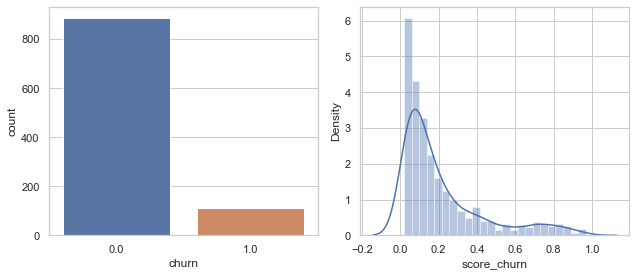

In [27]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(9,4))
sns.countplot(base_test['churn'].apply(str), ax=axs[0])
sns.distplot(base_test['score_churn'], ax=axs[1])
fig.tight_layout()

In [28]:
print('A Disposição da variável resposta na base de dados é:'),
print(round((base_test['churn'].value_counts()/base_test.shape[0])*100,2),'em %')

A Disposição da variável resposta na base de dados é:
0.0    88.7
1.0    11.3
Name: churn, dtype: float64 em %


In [29]:
base_test.head()

,RowNumber,CustomerId,Surname,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender_Male,Geography_Germany,Geography_Spain,score_churn,churn
0,10001,15798485,Copley,565,31,1,0.00,1.0,0,1,20443.08,1,0,0,0.079376,0.0
1,10002,15588959,T'ang,569,34,4,0.00,1.0,0,1,4045.90,1,0,0,0.083401,0.0
2,10003,15624896,Ku,669,20,7,0.00,2.0,1,0,128838.67,0,0,0,0.041323,0.0
3,10004,15639629,McConnan,694,39,4,173255.48,1.0,1,1,81293.10,1,0,0,0.119940,0.0
4,10005,15638852,Ts'ui,504,28,10,109291.36,1.0,1,1,187593.15,1,0,1,0.081515,0.0


## 4. Exportação da Base de Teste com predições 

In [31]:
base_test[['RowNumber','churn']].to_csv('predicoes_churn.csv',header=True,index=False)